In [1]:
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

NUMBER_OF_STEPS = 1000000
SAMPLE_INTERVAL = 1

length = int(NUMBER_OF_STEPS/SAMPLE_INTERVAL)
x_list = np.zeros(length, dtype=float)
v_list = np.zeros(length, dtype=float)
inv_list = np.zeros(length, dtype=float)
vel_eta_list = np.zeros(length, dtype=float)

def nh(pos_eta, vel_eta, mas_eta, Ek2, kT, dN, dt2):
    dt4 = dt2 * 0.5

    G = Ek2 - dN * kT
    vel_eta[0] = vel_eta[0] + dt4 * G

    pos_eta[0] += dt2 * vel_eta[0] / mas_eta

    # Compute the scale factor
    factor = math.exp(-dt2 * vel_eta[0] / mas_eta)

    # Update thermostat velocities from 0 to M - 2:
    G = Ek2 * factor * factor - dN * kT
    vel_eta[0] = vel_eta[0] + dt4 * G

    return factor


# Main simulation loop
dN = 1.0
dt = 0.01
dt2 = dt * 0.5
kT = 1
x = 0
v = 1
mass = 1.0
k_spring = 1
f = -k_spring * x
pos_eta = [0.0]
vel_eta = [1]
mas_eta = 1

Ek2 = 0.0
factor = 0.0

for step in tqdm(range(NUMBER_OF_STEPS)):
    inv = mass * v * v * 0.5 + k_spring * x * x * 0.5
    inv += kT * dN * pos_eta[0]
    Ek2 = v * v * mass
    factor = nh(pos_eta, vel_eta, mas_eta, Ek2, kT, dN, dt2)
    v *= factor

    v += dt2 * (f / mass)
    x += dt * v
    f = -k_spring * x
    v += dt2 * (f / mass)

    if step % SAMPLE_INTERVAL == 0:
        nn = int(step/SAMPLE_INTERVAL)
        x_list[nn] = x
        v_list[nn] = v
        inv_list[nn] = inv
        vel_eta_list[nn] = vel_eta[0]

    Ek2 = v * v * mass
    factor = nh(pos_eta, vel_eta, mas_eta, Ek2, kT, dN, dt2)
    v *= factor

100%|██████████| 1000000/1000000 [00:02<00:00, 365191.56it/s]


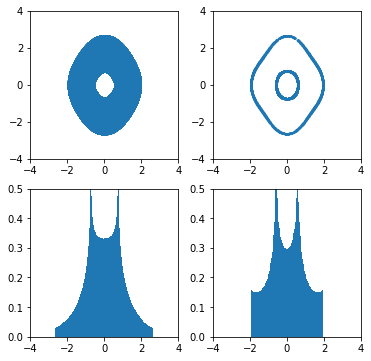

In [2]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(x_list, v_list, s=1)
axs[0, 0].set_xlim(-4, 4)
axs[0, 0].set_ylim(-4, 4)
axs[0, 0].set_aspect(1)

choose = (vel_eta_list >= -0.01) & (vel_eta_list <= 0.01)
axs[0, 1].scatter(x_list[choose], v_list[choose], s=1)
axs[0, 1].set_xlim(-4, 4)
axs[0, 1].set_ylim(-4, 4)
axs[0, 1].set_aspect(1)

axs[1, 0].hist(v_list, density=True, bins=100)
axs[1, 0].set_xlim(-4, 4)
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].set_box_aspect(1)

axs[1, 1].hist(x_list, density=True, bins=100)
axs[1, 1].set_xlim(-4, 4)
axs[1, 1].set_ylim(0, 0.5)
axs[1, 1].set_box_aspect(1)
fig.set_size_inches(6, 6)

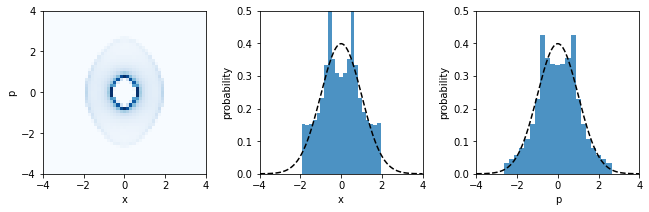

In [12]:
fig, axs = plt.subplots(1, 3)
axs[0].hist2d(x_list, v_list, bins=51, range=[[-4, 4], [-4, 4]],
              cmap="Blues", density=True)
axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-4, 4)
axs[0].set_xlabel("x")
axs[0].set_ylabel("p")
axs[0].set_xticks([-4, -2, 0, 2, 4])
axs[0].set_yticks([-4, -2, 0, 2, 4])
axs[0].set_aspect(1)

position = np.linspace(-4, 4, 500)
boltz_factor = np.exp(-0.5/kT*k_spring*position**2)
Z = np.trapz(boltz_factor, position)
boltz_factor /= Z
axs[1].plot(position, boltz_factor, color="k", linestyle="--")
axs[2].plot(position, boltz_factor, color="k", linestyle="--")

axs[1].hist(x_list, density=True, bins=21, alpha=0.8)
axs[1].set_xlim(-4, 4)
axs[1].set_ylim(0, 0.5)
axs[1].set_box_aspect(1)
axs[1].set_xlabel("x")
axs[1].set_ylabel("probability")
axs[1].set_xticks([-4, -2, 0, 2, 4])

axs[2].hist(v_list, density=True, bins=21, alpha=0.8)
axs[2].set_xlim(-4, 4)
axs[2].set_ylim(0, 0.5) 
axs[2].set_box_aspect(1)
axs[2].set_xlabel("p")
axs[2].set_ylabel("probability")
axs[2].set_xticks([-4, -2, 0, 2, 4])

fig.set_size_inches(11, 3)
plt.savefig("md_ho_nh.pdf", bbox_inches="tight")
plt.show()